In [1]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from clickhouse_driver import Client

client = Client('localhost', database="testupdateddb")

In [2]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)
print(len(exp_df.exp_id.unique().tolist()))
print("\n".join(exp_df.exp_id.unique().tolist()))
print()
exp_df

2
TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client
TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client

CPU times: user 13.2 ms, sys: 0 ns, total: 13.2 ms
Wall time: 16.3 ms


,exp_id,attacker_rate,server_connections,max_keep_alive_requests,num_clients,num_trials,origin_server_duration,attacker_duration,receiver_duration,proxy_duration,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,8,1,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,0mbps,256,0,8,1,140,30,140,140,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False


In [3]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{client_node_ids=}")

client_dnids={2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21}
attacker_dnids={1, 13}
client_node_ids={2, 3, 4, 5, 6, 7, 8, 9}
CPU times: user 3.76 ms, sys: 2.14 ms, total: 5.9 ms
Wall time: 9.53 ms


In [4]:
client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id", how="left")

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' '']


,exp_id,trial,observer_id,message_marker,response_code,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,1,content,0.000000,0.331548,0.000000,0.000000,0.331548,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,2,content,0.347197,0.406366,0.347197,0.347197,0.406366,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
2,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,3,content,0.408775,0.468480,0.408775,0.408775,0.468480,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
3,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,4,content,0.470538,0.527759,0.470538,0.470538,0.527759,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
4,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,5,content,0.530176,0.586225,0.530176,0.530176,0.586225,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35487,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,client8,17698,content,125.773819,125.826693,125.773819,125.773819,125.826693,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False
35488,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,client8,17699,content,125.827484,125.880456,125.827484,125.827484,125.880456,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False
35489,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,client8,17700,content,125.881220,125.934215,125.881220,125.881220,125.934215,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False
35490,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,client8,17701,content,125.934998,125.988008,125.934998,125.934998,125.988008,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False


In [5]:
%%time

client_sends_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
)

SELECT * FROM client_sends
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_sends_df = client.query_dataframe(client_sends_sql)
client_sends_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_sends_df

CPU times: user 89.5 ms, sys: 6.56 ms, total: 96 ms
Wall time: 209 ms


,exp_id,observe_timestamp,trial,observer_id,message_marker,coap_retransmitted
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,0.000000,1,client1,1,False
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,0.347197,1,client1,2,False
2,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,0.408775,1,client1,3,False
3,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,0.470538,1,client1,4,False
4,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,0.530176,1,client1,5,False
...,...,...,...,...,...,...
35487,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.773819,1,client8,17698,False
35488,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.827484,1,client8,17699,False
35489,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.881220,1,client8,17700,False
35490,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.934998,1,client8,17701,False


In [6]:
%%time

client_recvs_sql = f"""
WITH client_recvs AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT * FROM client_recvs
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_recvs_df = client.query_dataframe(client_recvs_sql)
client_recvs_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_recvs_df["successful_message"] = False
client_recvs_df.loc[(client_recvs_df["response_code"] == "content"), "successful_message"] = True

print(client_recvs_df["response_code"].unique())

client_recvs_df

['content']
CPU times: user 79.4 ms, sys: 19.6 ms, total: 99 ms
Wall time: 190 ms


,exp_id,observe_timestamp,trial,observer_id,message_marker,response_code,successful_message
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,0.331548,1,client1,1,content,True
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,0.406366,1,client1,2,content,True
2,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,0.468480,1,client1,3,content,True
3,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,0.527759,1,client1,4,content,True
4,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,0.586225,1,client1,5,content,True
...,...,...,...,...,...,...,...
35471,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.773018,1,client8,17697,content,True
35472,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.826693,1,client8,17698,content,True
35473,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.880456,1,client8,17699,content,True
35474,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,125.934215,1,client8,17700,content,True


In [7]:
%%time

(
  message_rtt_df.groupby(by=["exp_id", "trial", "observer_id"])
  .agg(
    avg_rtt_ms_first_transmission=("rtt_ms_first_transmission", "mean"),
    avg_rtt_ms_last_transmission=("rtt_ms_last_transmission", "mean"),
    num_unique_messages=("message_marker", "nunique"),
    num_messages=("message_marker", "count"),
    num_successful_messages=("successful_message", "sum"),
    num_send_messages=("num_send_observations", "sum"),
    num_recv_messages=("num_recv_observations", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
  )
)

CPU times: user 50.3 ms, sys: 0 ns, total: 50.3 ms
Wall time: 47.8 ms


avg_rtt_ms_first_transmission  \
exp_id                                                                                                            trial observer_id                                  
TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client 1     client1                          52.853099   
                                                                                                                        client2                          52.681291   
                                                                                                                        client3                          52.664093   
                                                                                                                        client4                          52.622685   
                                                                                                                        client5                          52.629680   
                                                                                                                        client6                          52.622482   
                                                                                                                        client7                          52.612132   
                                                                                                                        client8                          52.602458   
TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client 1     client1                          53.031705   
                                                                                                                        client2                          52.920074   
                                                                                                                        client3                          52.863725   
                                                                                                                        client4                          52.821411   
                                                                                                                        client5                          52.827405   
                                                                                                                        client6                          52.802776   
                                                                                                                        client7                          52.777646   
                                                                                                                        client8                          52.774186   

                                                                                                                                     avg_rtt_ms_last_transmission  \
exp_id                                                                                                            trial observer_id                                 
TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client 1     client1                         52.853099   
                                                                                                                        client2                         52.681291   
                                                                                                                        client3                         52.664093   
                                                                                                                        client4                         52.622685   
                                                                                                                        client5                         52

In [8]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df = metric_df.merge(exp_df, on="exp_id", how="left")

metric_df

CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 20.4 ms


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,cpu_utilization,1.513571,0.5,9.5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,cpu_utilization,3.134286,0.5,21.1,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
2,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,memory_utilization,278.600660,265.0,280.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
3,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,memory_utilization,448.279339,244.0,487.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
4,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,cpu_utilization,1.492143,0.5,10.5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False
5,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,cpu_utilization,3.392143,0.4,27.8,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False
6,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,memory_utilization,279.458746,265.0,281.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False
7,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,memory_utilization,466.218182,245.0,502.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False


In [9]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    mean_rtt_ms=("rtt_ms_first_transmission", "mean"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p90=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.90)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

client_rps_df

CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 198 ms


,exp_id,trial,observer_id,num_messages,num_successful_messages,mean_rps,max_num_retransmissions,total_num_retransmissions,stddev_rtt_ms,min_rtt_ms,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,2222,2221,18.508333,0,0,6.033843,51.774979,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,reuse-connections,coap,https,no-attacker
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client2,2228,2227,18.558333,0,0,0.565203,51.702976,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,reuse-connections,coap,https,no-attacker
2,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client3,2228,2227,18.558333,0,0,0.966367,51.687002,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,reuse-connections,coap,https,no-attacker
3,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client4,2231,2230,18.583333,0,0,0.484272,51.715136,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,reuse-connections,coap,https,no-attacker
4,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client5,2231,2230,18.583333,0,0,0.453892,51.751137,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,reuse-connections,coap,https,no-attacker
5,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client6,2231,2230,18.583333,0,0,0.852362,51.790953,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,reuse-connections,coap,https,no-attacker
6,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client7,2231,2230,18.583333,0,0,1.048177,51.862955,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,reuse-connections,coap,https,no-attacker
7,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client8,2232,2231,18.591667,0,0,0.820538,51.767111,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,reuse-connections,coap,https,no-attacker
8,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,2199,2198,18.316667,0,0,5.325501,51.862001,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,reuse-connections,dtls,https,no-attacker
9,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,client2,2204,2203,18.358333,0,0,1.409340,51.885843,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,reuse-connections,dtls,https,no-attacker


In [10]:
### Prepare for dev graphing.

import matplotlib as mpl
inline_rc = dict(mpl.rcParams)
mpl.rcParams.update(mpl.rcParamsDefault)

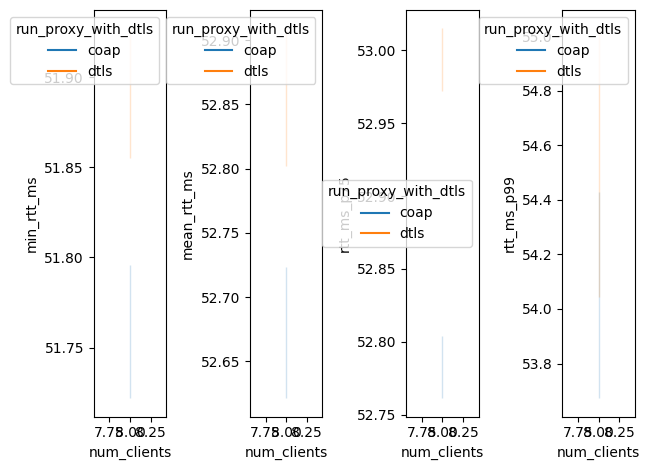

In [11]:
df = client_rps_df

ys = ["min_rtt_ms", "mean_rtt_ms", "rtt_ms_p75", "rtt_ms_p99"]
fig, ax = plt.subplots(1, len(ys))
for i, y in enumerate(ys):
  g = sns.lineplot(
    data=df,
    x="num_clients",
    y=y,
    hue="run_proxy_with_dtls",
    ax=ax[i]
  )

fig.tight_layout()
plt.show()

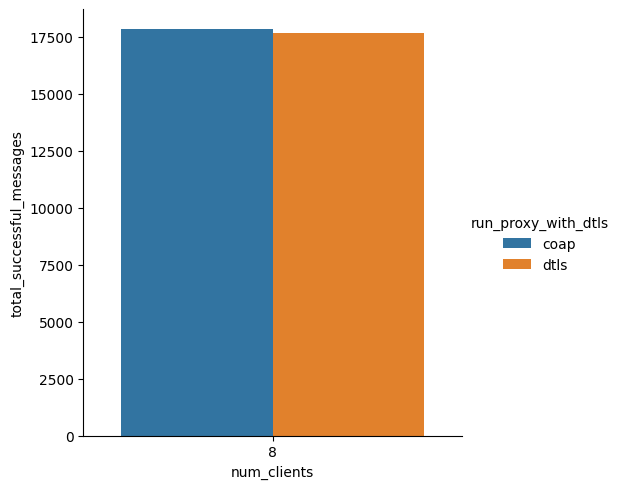

,exp_id,run_proxy_with_dtls,num_clients,trial,total_successful_messages
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,coap,8,1,17826
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,dtls,8,1,17650


In [12]:
df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum")
  )
  .reset_index()
)

g = sns.catplot(
  data=df,
  x="num_clients",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  kind="bar",
)

plt.show()

df

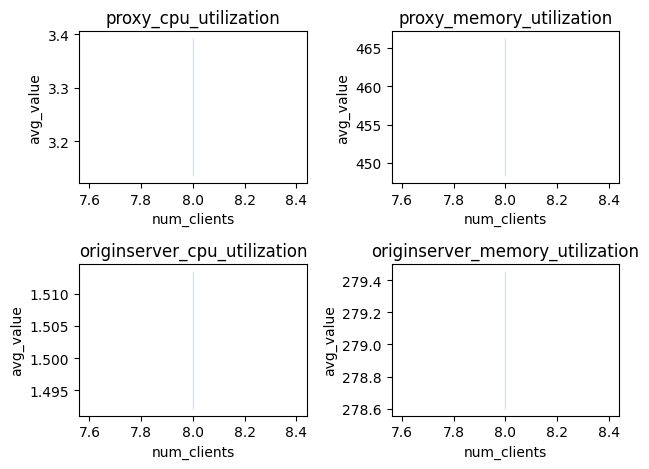

,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,cpu_utilization,1.513571,0.5,9.5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,cpu_utilization,3.134286,0.5,21.1,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
2,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,memory_utilization,278.600660,265.0,280.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
3,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,memory_utilization,448.279339,244.0,487.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,False,True,False
4,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,cpu_utilization,1.492143,0.5,10.5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False
5,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,cpu_utilization,3.392143,0.4,27.8,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False
6,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,originserver,memory_utilization,279.458746,265.0,281.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False
7,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,memory_utilization,466.218182,245.0,502.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,True,True,False


In [13]:
df = metric_df

nodes = ["proxy", "originserver"]
metric_types = ["cpu_utilization", "memory_utilization"]
fig, ax = plt.subplots(len(metric_types), len(nodes))
for i, n in enumerate(nodes):
  for j, m in enumerate(metric_types):
    g = sns.lineplot(
      data=df[
        (df["observer_id"] == n)
        & (df["metric_type"] == m)
      ],
      x="num_clients",
      y="avg_value",
      ax=ax[i,j],
    )
    ax[i,j].set_title(f"{n}_{m}")

fig.tight_layout()
plt.show()

df

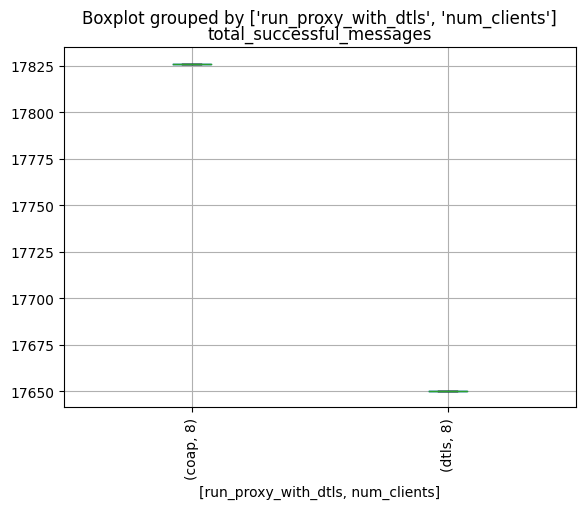

,,,,total_successful_messages
exp_id,run_proxy_with_dtls,num_clients,trial,
TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,coap,8,1,17826
TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,dtls,8,1,17650


In [14]:
df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum")
  )
)
param_comparison_scope = ["run_proxy_with_dtls", "num_clients"]

plot_args = {
  "rot": 90,
  "by": param_comparison_scope,
}

df.boxplot("total_successful_messages", **plot_args)

plt.show()

df

In [15]:
### At this point, we generate figures for the paper

plt.rcParams['figure.dpi']  = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size']        = '18'
plt.rcParams['lines.linewidth']  = 3
plt.rcParams['lines.markersize'] = 9

client_rps_df.replace({
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    "dtls": "CoAPS",
  }
}, inplace=True)
metric_df.replace({
  "run_proxy_with_dtls": {
    False: "CoAP",
    True : "CoAPS",
  }
}, inplace=True)

In [16]:
### At this point, we generate figures for the paper

client_rps_df.replace({
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    "dtls": "CoAPS",
  }
}, inplace=True)

def get_properties(y):
  if y == "mean_rtt_ms":
    title = "Meant Client RTT in Milliseconds"
    ylabel = title + " Milliseconds"
  elif y == "rtt_ms_p99":
    title = "99th Percentile Client RTT in Milliseconds"
    ylabel = title + " in Milliseconds"
  else:
    raise Exception()

  ylabel = "Client RTT in Milliseconds"
  
  return {
    "ylabel": ylabel,
    "title": title,
  }

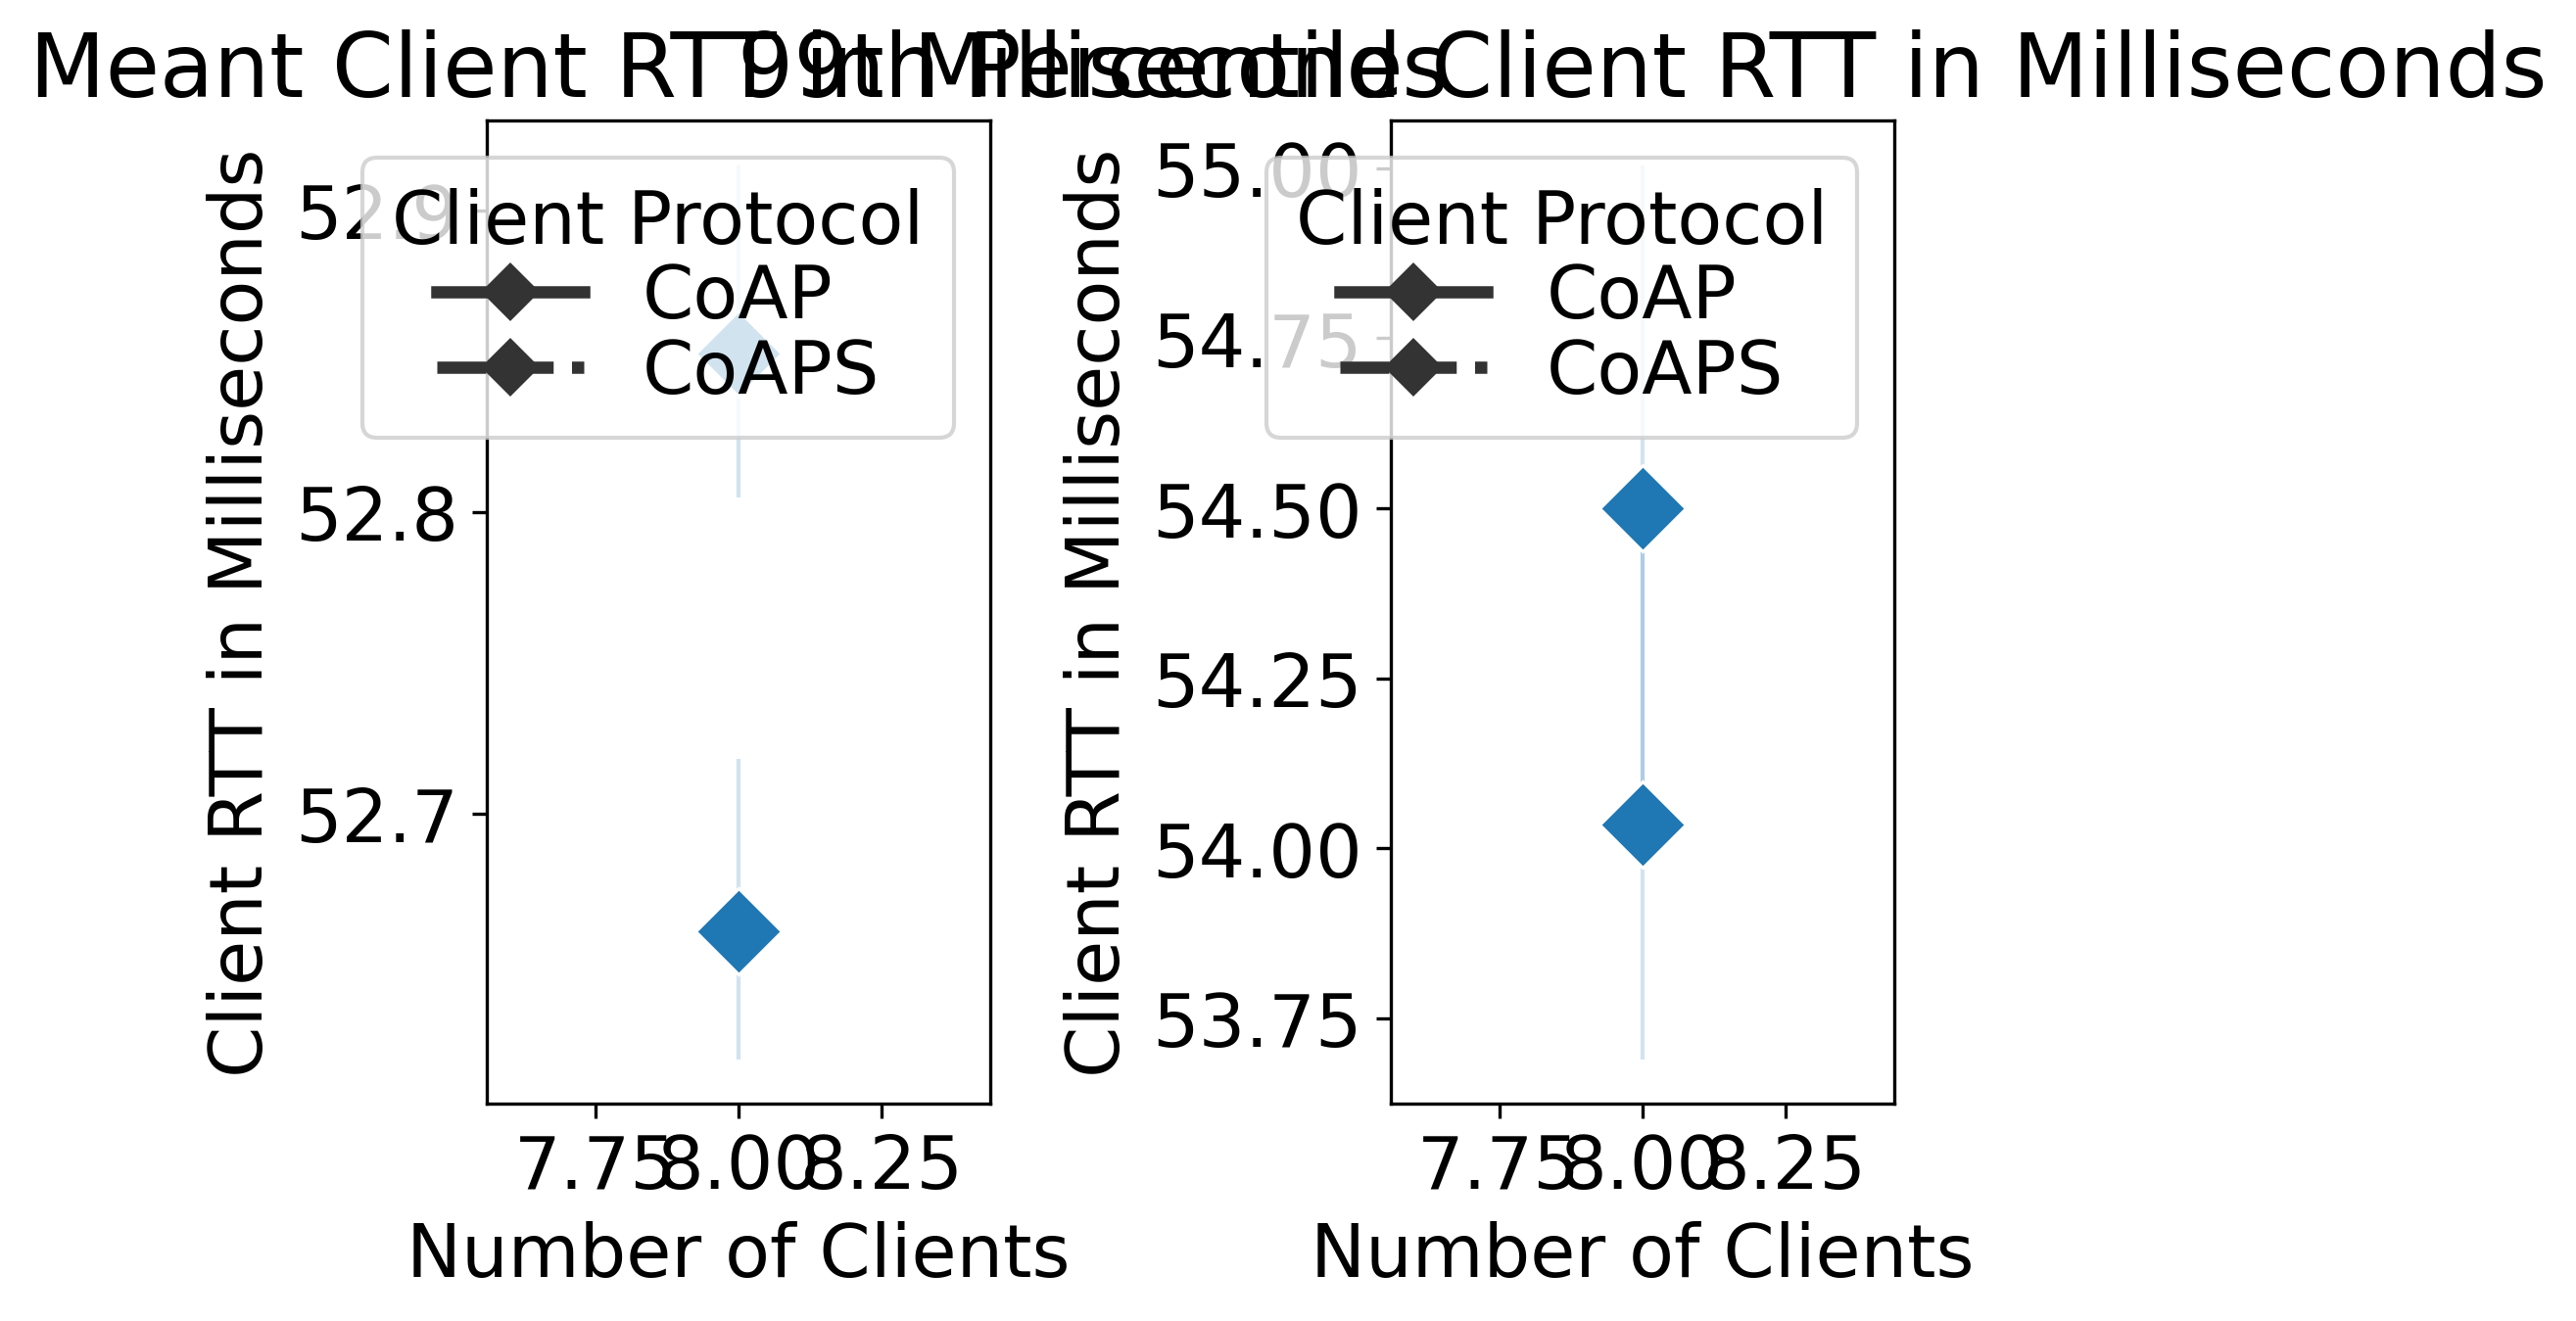

In [17]:
### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df

ys = ["mean_rtt_ms", "rtt_ms_p99"]
fig, ax = plt.subplots(1, len(ys))
for i, y in enumerate(ys):
  g = sns.lineplot(
    data=df,
    x="num_clients",
    y=y,
    style="run_proxy_with_dtls",
    ax=ax[i],
    markers=["D", "D"],
    markersize=15,
  )

  sns.move_legend(
    g, 
    "upper right", 
    title="Client Protocol", 
    frameon=True, 
    labelspacing=0.05,
    bbox_to_anchor=((1, 1)),
    markerfirst=True,
  )

  props = get_properties(y)
  ax[i].set_xlabel("Number of Clients")
  ax[i].set_ylabel(props["ylabel"])
  ax[i].set_title(props["title"])

fig.tight_layout(pad=1)
plt.show()

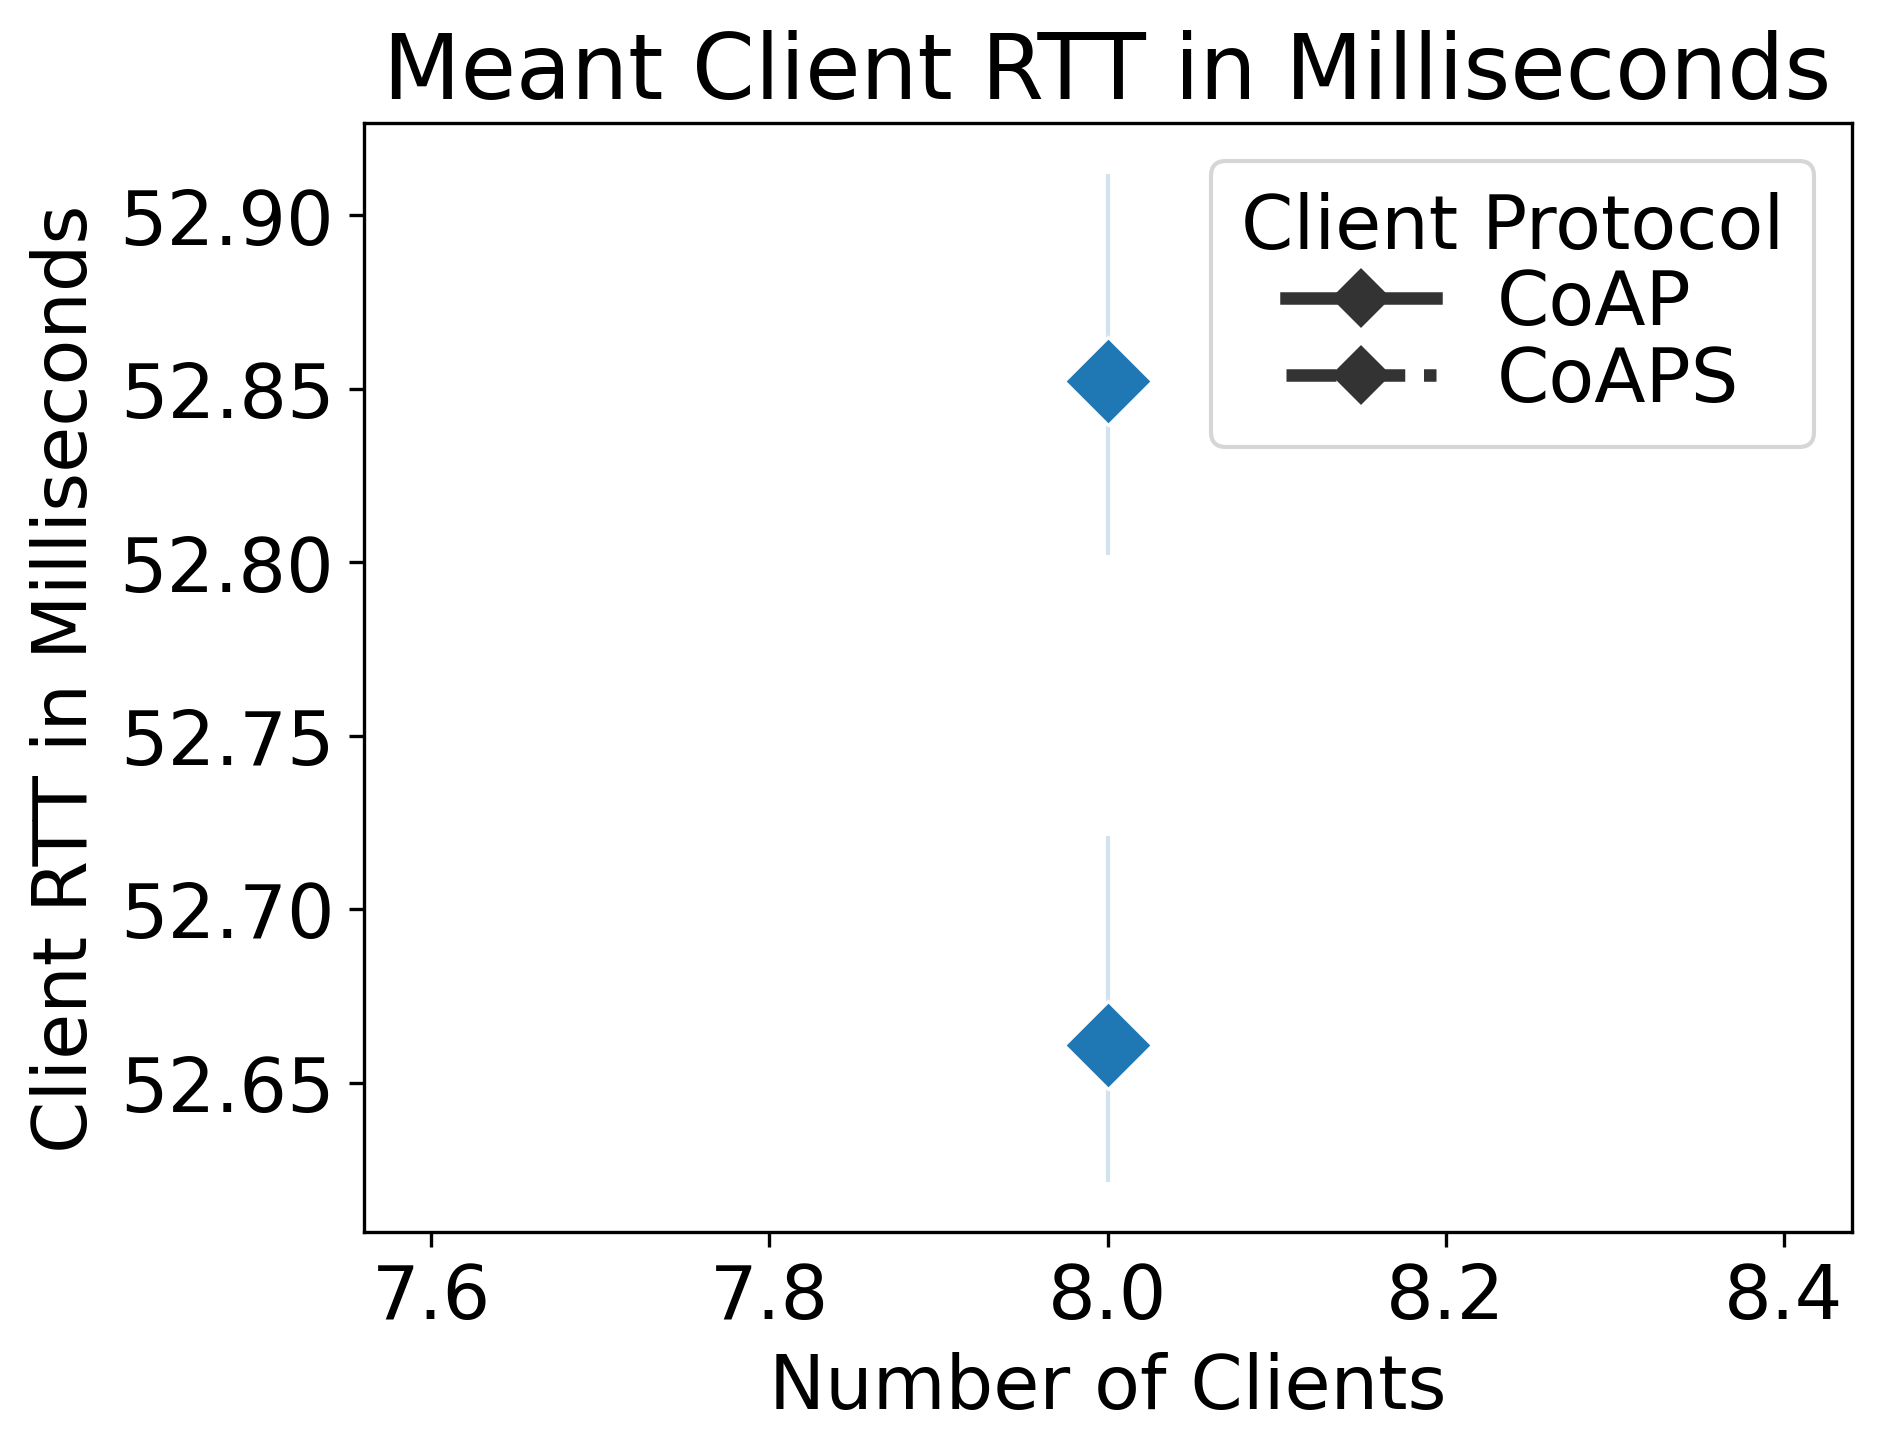

In [18]:
### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df

y="mean_rtt_ms"

g = sns.lineplot(
  data=df,
  x="num_clients",
  y=y,
  style="run_proxy_with_dtls",
  markers=["D", "D"],
  markersize=15,
)

sns.move_legend(
  g, 
  "upper right", 
  title="Client Protocol", 
  frameon=True, 
  labelspacing=0.05,
  bbox_to_anchor=((1, 1)),
  markerfirst=True,
)

props = get_properties(y)
g.set_xlabel("Number of Clients")
g.set_ylabel(props["ylabel"])
g.set_title(props["title"])

plt.show()

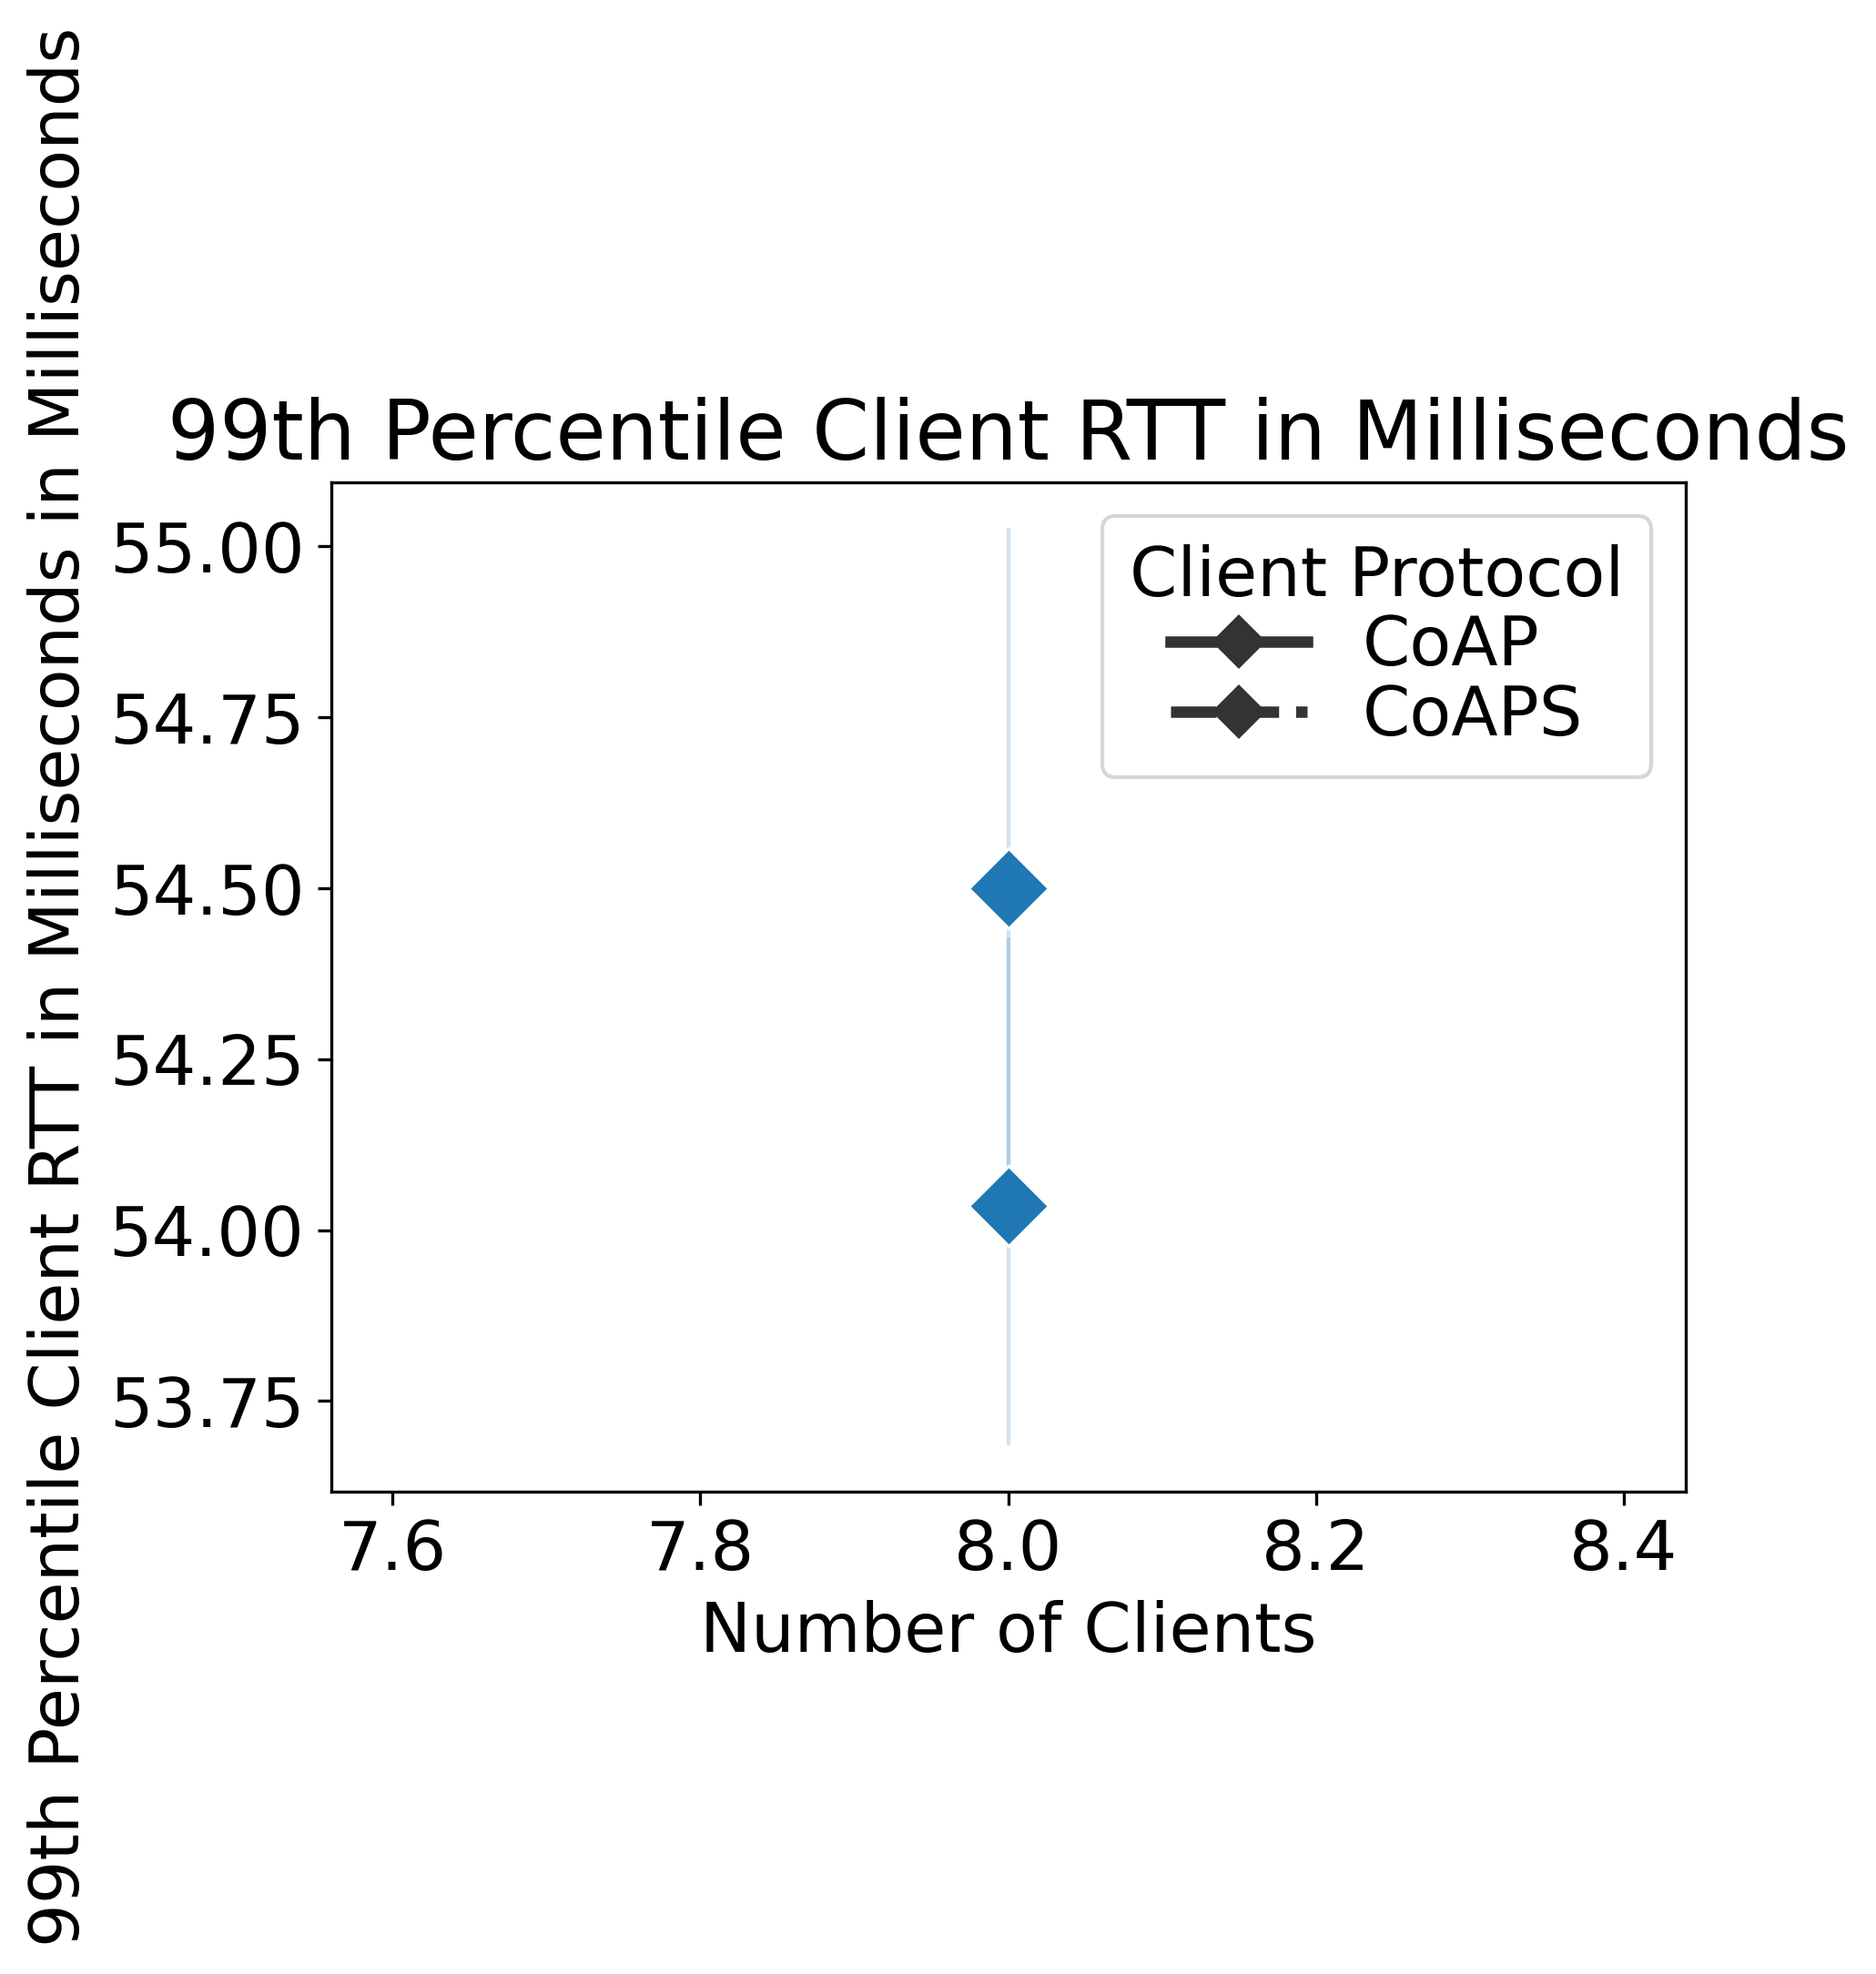

In [19]:
### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df

def get_properties(y):
  if y == "mean_rtt_ms":
    title = "Meant Client RTT in Milliseconds"
    ylabel = title + " Milliseconds"
  elif y == "rtt_ms_p99":
    title = "99th Percentile Client RTT in Milliseconds"
    ylabel = title + " in Milliseconds"
  else:
    raise Exception()
  
  return {
    "ylabel": ylabel,
    "title": title,
  }

y="rtt_ms_p99"

g = sns.lineplot(
  data=df,
  x="num_clients",
  y=y,
  style="run_proxy_with_dtls",
  markers=["D", "D"],
  markersize=15,
)

sns.move_legend(
  g, 
  "upper right", 
  title="Client Protocol", 
  frameon=True, 
  labelspacing=0.05,
  bbox_to_anchor=((1, 1)),
  markerfirst=True,
)

props = get_properties(y)
g.set_xlabel("Number of Clients")
g.set_ylabel(props["ylabel"])
g.set_title(props["title"])

plt.show()

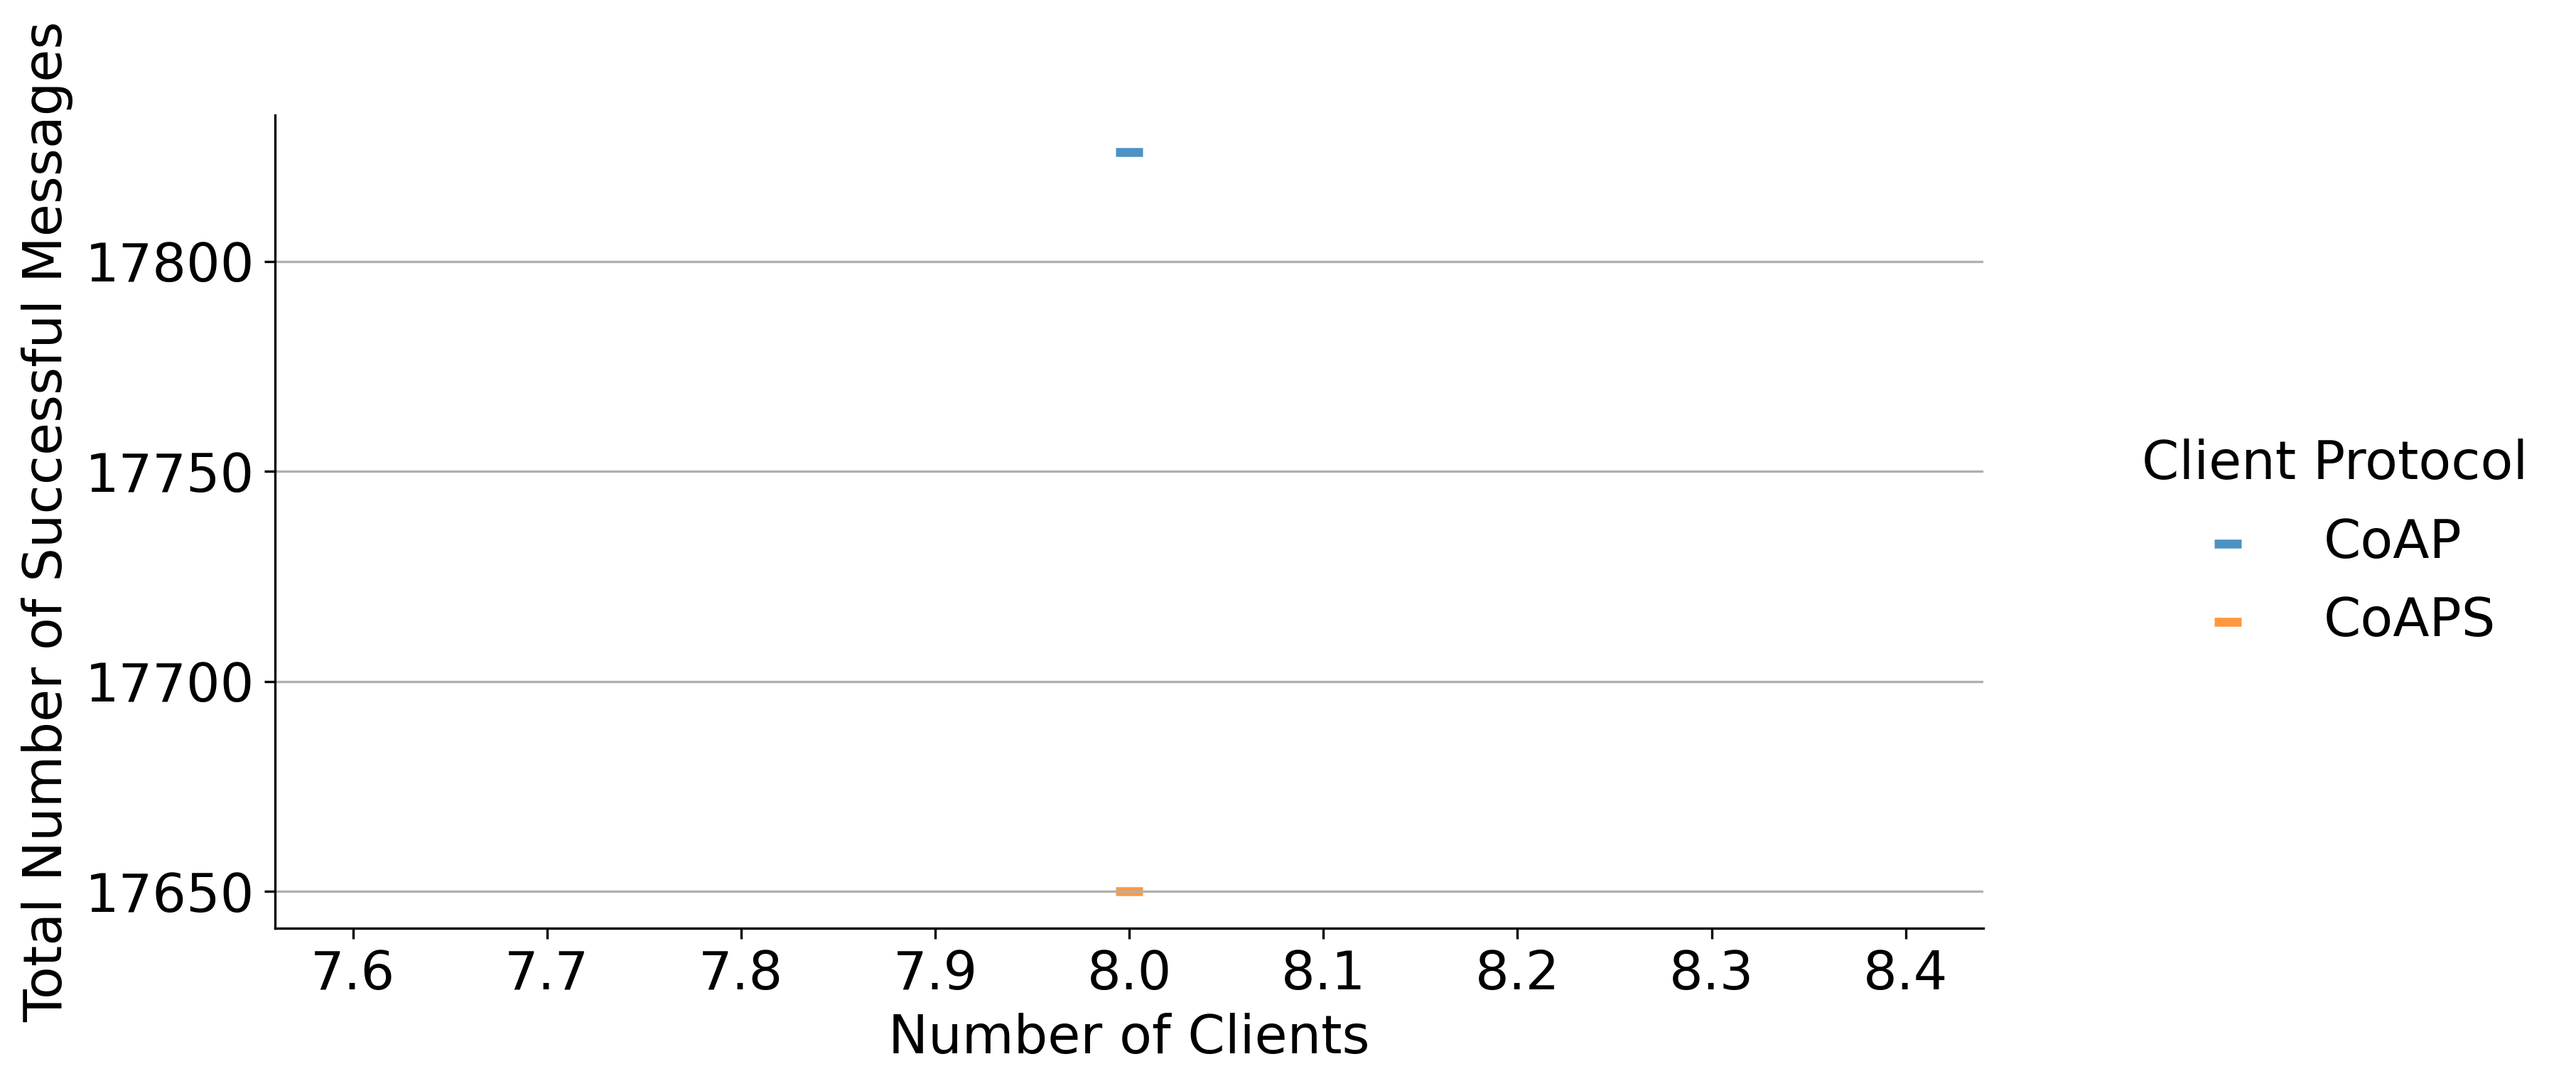

,exp_id,run_proxy_with_dtls,num_clients,trial,total_successful_messages,mean_active_time_sec,amortized_successful_rps
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,CoAP,8,1,17826,119.150537,18.701133
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,CoAPS,8,1,17650,118.913081,18.553468


In [20]:
## Plot total number of successful messages.

client_rps_df["active_time_sec"] = client_rps_df["last_active_time"] - client_rps_df["first_active_time"]

df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum"),
    mean_active_time_sec=("active_time_sec", "mean"),
  )
  .reset_index()
)
df["amortized_successful_rps"] = df["total_successful_messages"] / df["mean_active_time_sec"] / df["num_clients"]

g = sns.lmplot(
  data=df,
  x="num_clients",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  aspect=2,
  markers=["_", "_"],
  scatter=True,
  fit_reg=False,
)

g.set_xlabels("Number of Clients")
g.set_ylabels("Total Number of Successful Messages")
g.legend.set_title("Client Protocol")
# g.refline(
#   y=100.0,
#   color="black",
#   linestyle="solid",
#   linewidth=0.05,
# )

plt.grid(True, axis="y")
plt.show()

df

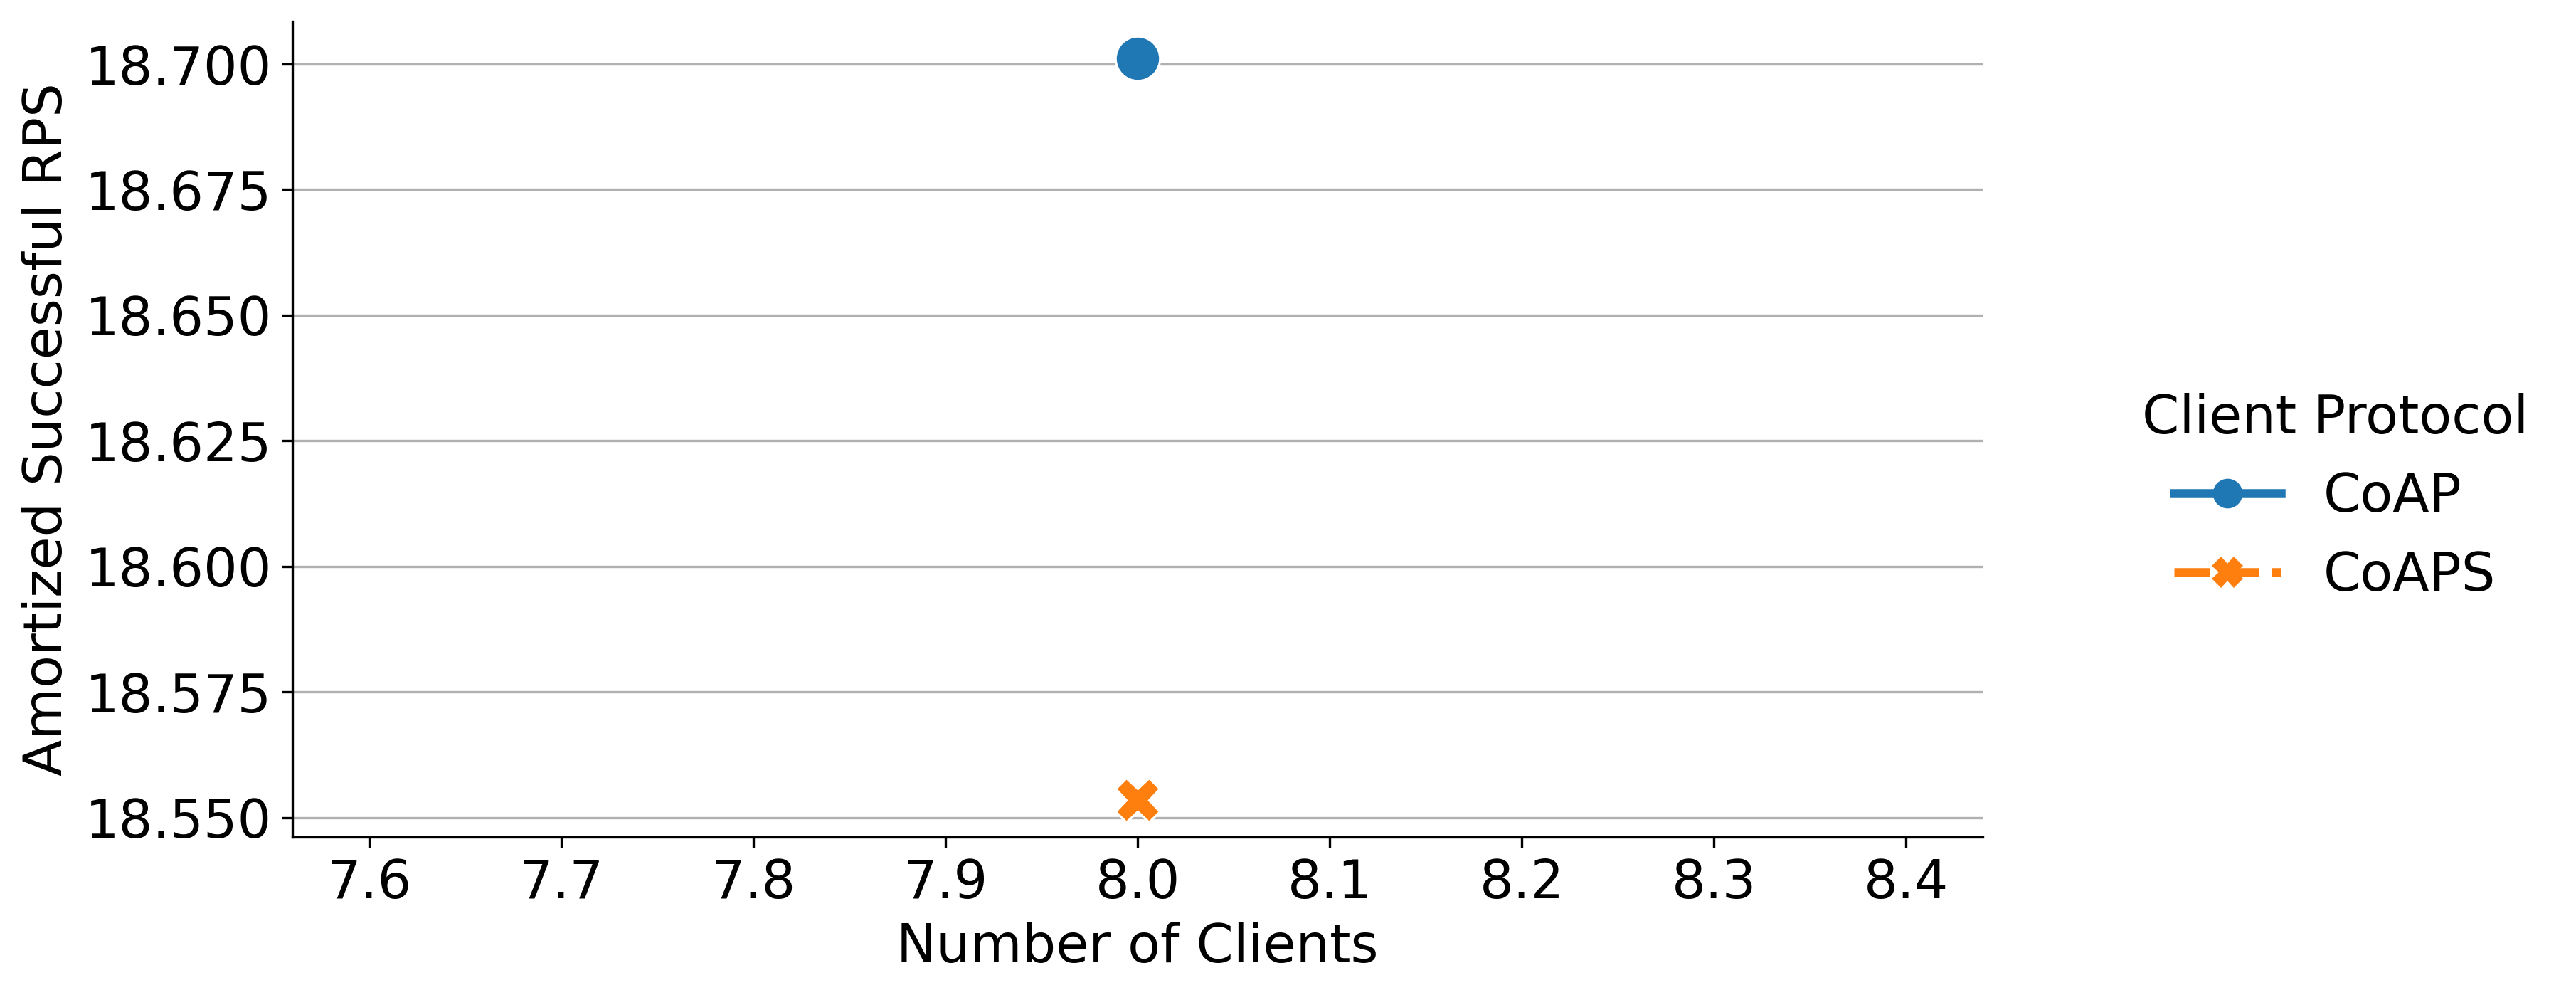

,exp_id,run_proxy_with_dtls,num_clients,trial,total_successful_messages,mean_active_time_sec,amortized_successful_rps
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,CoAP,8,1,17826,119.150537,18.701133
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,CoAPS,8,1,17650,118.913081,18.553468


In [21]:
g = sns.relplot(
  data=df,
  kind="line",
  x="num_clients",
  y="amortized_successful_rps",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  aspect=2,
  markers=True,
  markersize=15,
)

g.set_xlabels("Number of Clients")
g.set_ylabels("Amortized Successful RPS")
g.legend.set_title("Client Protocol")
# g.refline(
#   y=100.0,
#   color="black",
#   linestyle="solid",
#   linewidth=0.05,
# )

plt.grid(True, axis="y")
plt.show()

df

In [22]:
## Plot retransmissions as a function of clients and protocol.

df = (
  client_rps_df.groupby(by=["exp_id", "trial", "num_clients", "run_proxy_with_dtls"])
  .agg(
    total_num_retransmissions=("total_num_retransmissions", "sum")
  )
  .reset_index()
)

# Makes no sense to graph since there are no retransmissions.
# g = sns.catplot(
#   data=df,
#   kind="bar",
#   x="num_clients",
#   y="total_num_retransmissions",
#   hue="run_proxy_with_dtls",
# )
# plt.show()

df[df["total_num_retransmissions"] > 0]

,exp_id,trial,num_clients,run_proxy_with_dtls,total_num_retransmissions


In [23]:
%%time

## Determine transaction success rate

# Combine send and receive events for clients.
client_events_df = client_sends_df.merge(client_recvs_df, on=["exp_id", "trial", "observer_id", "message_marker"], how="left")
client_events_df.rename(columns={
  "observe_timestamp_x": "send_timestamp",
  "observe_timestamp_y": "recv_timestamp",
}, inplace=True)
client_events_df["rtt_ms"] = 1e3 * (client_events_df["recv_timestamp"] - client_events_df["send_timestamp"])

# Edge case: sometimes clients will not receive a
# response back at the end of the experiment, so
# we ignore those messages, if any.
grouped_last_nan_indicies_to_remove = (
  client_events_df.reset_index()[
    client_events_df["recv_timestamp"].isna()
  ]
  .groupby(by=["exp_id", "trial", "observer_id", "message_marker"])
  .agg(
    last_nan_recv_timestamp=("recv_timestamp", "last"),
    original_index=("index", "last"),
  )
  .reset_index()
  ["original_index"]
  .unique()
)
client_events_df.drop(index=grouped_last_nan_indicies_to_remove, inplace=True)
client_events_df.reset_index(inplace=True)
client_events_df.drop(columns=["index"], inplace=True)

# Produce the total number of messages, and number 
# messages with a matching successful response.
grouped_client_events_df = (
  client_events_df
  .groupby(["exp_id", "trial", "observer_id"])
  .agg(
    unique_message_markers=("message_marker", "nunique"),
    num_successful_messages=("successful_message", "sum"),
  )
  .reset_index()
)

# Now compute the successful transaction rate.
grouped_client_events_df["transaction_success_rate"] = 100 * grouped_client_events_df["num_successful_messages"] / grouped_client_events_df["unique_message_markers"]

grouped_client_events_df = (
  grouped_client_events_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

grouped_client_events_df

CPU times: user 155 ms, sys: 1 µs, total: 155 ms
Wall time: 154 ms


,exp_id,trial,observer_id,unique_message_markers,num_successful_messages,transaction_success_rate,attacker_rate,server_connections,max_keep_alive_requests,num_clients,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,2221,2221,100.0,0mbps,256,0,8,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client2,2227,2227,100.0,0mbps,256,0,8,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
2,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client3,2227,2227,100.0,0mbps,256,0,8,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
3,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client4,2230,2230,100.0,0mbps,256,0,8,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
4,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client5,2230,2230,100.0,0mbps,256,0,8,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
5,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client6,2230,2230,100.0,0mbps,256,0,8,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
6,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client7,2230,2230,100.0,0mbps,256,0,8,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
7,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,client8,2231,2231,100.0,0mbps,256,0,8,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
8,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,client1,2198,2198,100.0,0mbps,256,0,8,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAPS,True,False
9,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,client2,2203,2203,100.0,0mbps,256,0,8,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAPS,True,False


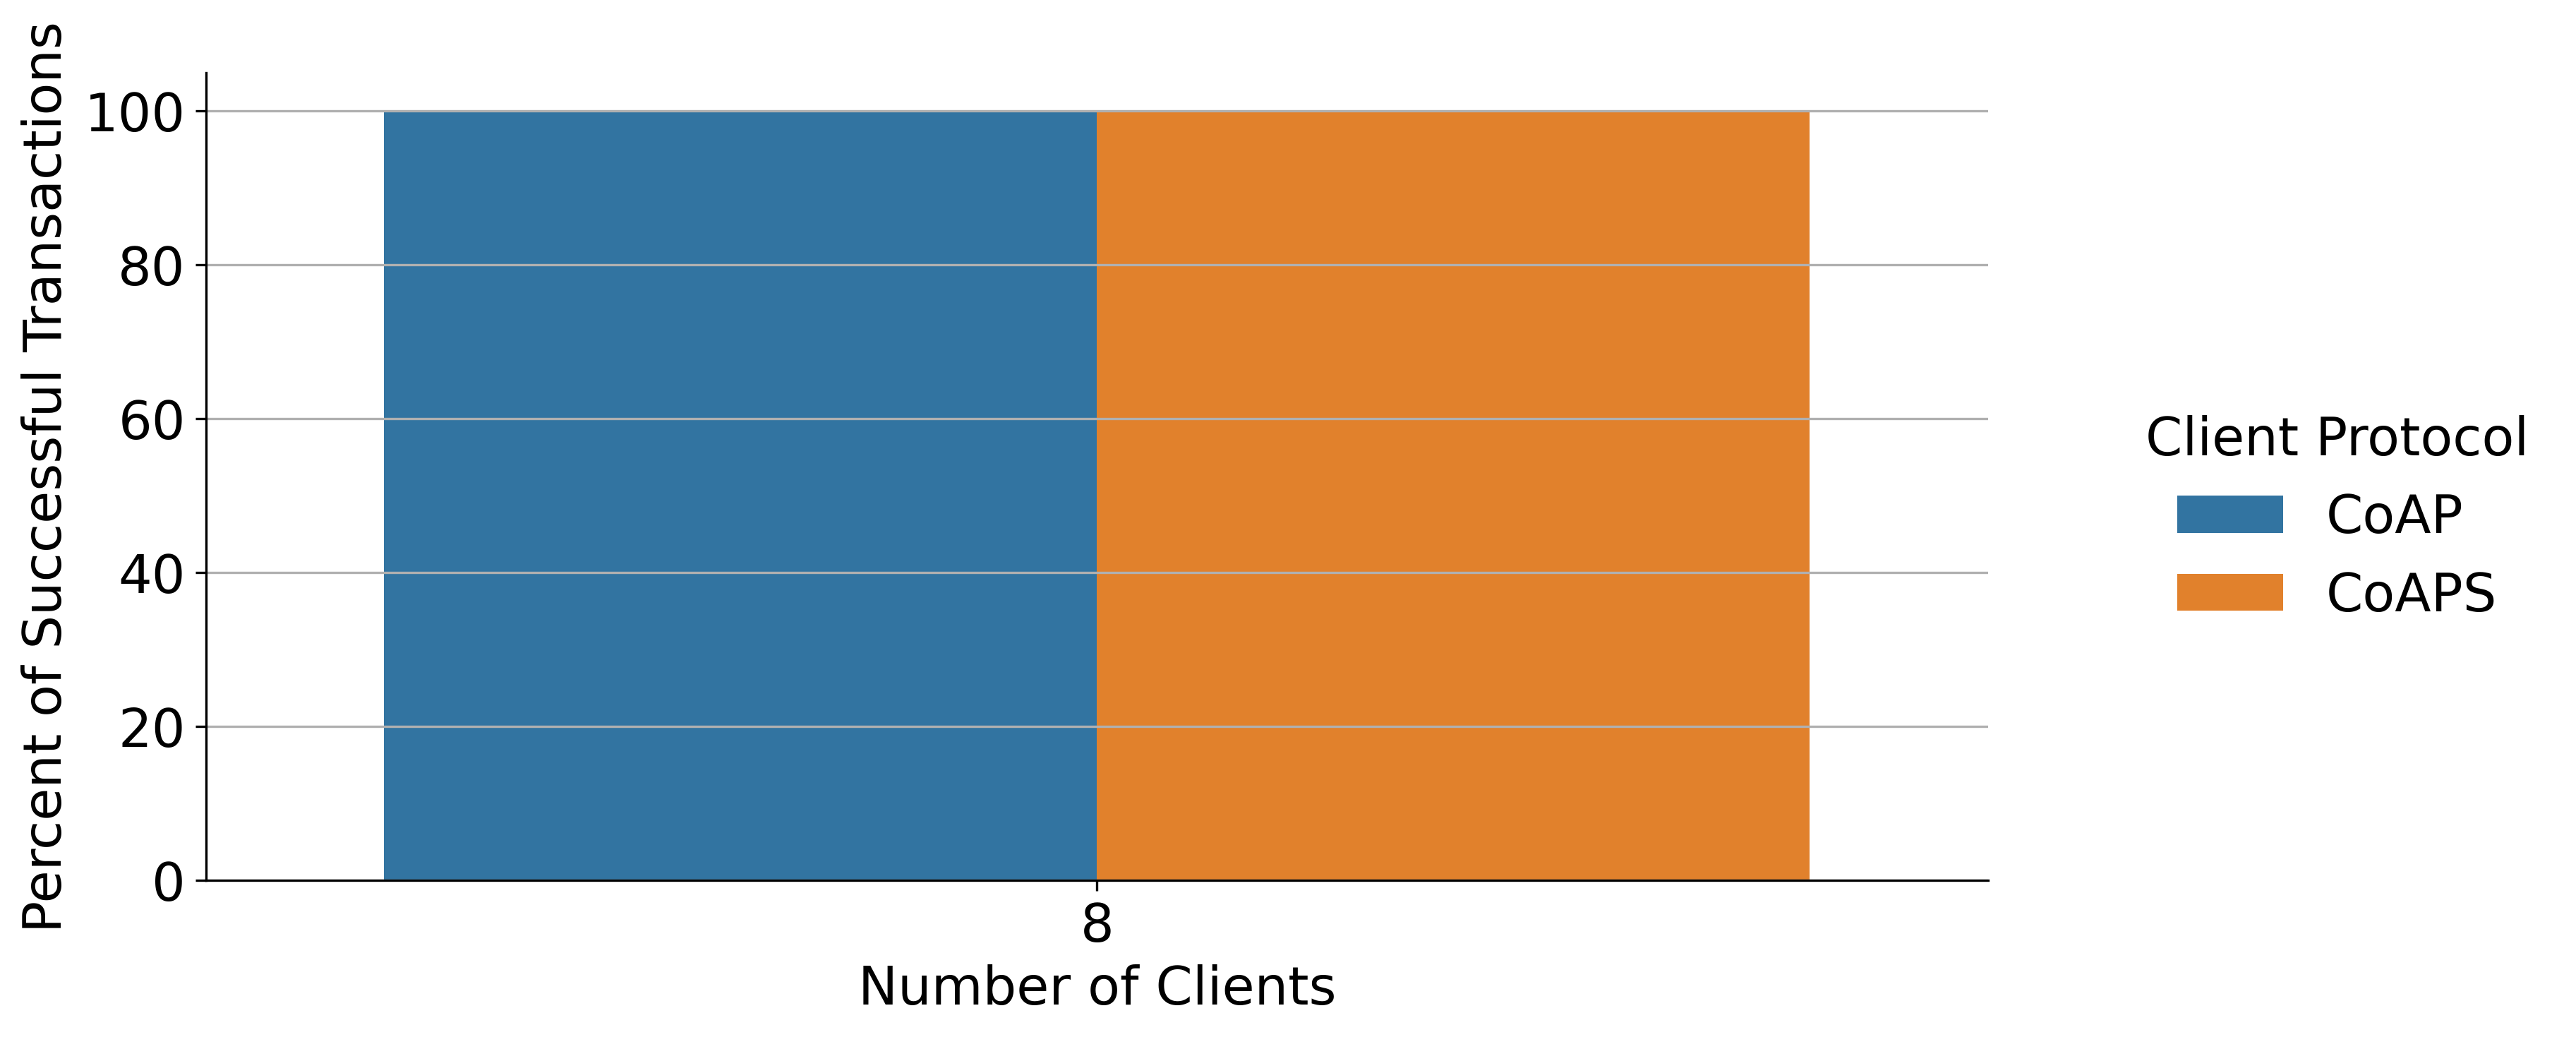

,exp_id,trial,observer_id,unique_message_markers,num_successful_messages,transaction_success_rate,attacker_rate,server_connections,max_keep_alive_requests,num_clients,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker


In [24]:
df = grouped_client_events_df

g = sns.catplot(
  data=df,
  kind="bar",
  x="num_clients",
  y="transaction_success_rate",
  hue="run_proxy_with_dtls",
  ci="sd",
  aspect=2,
)

g.set_xlabels("Number of Clients")
g.set_ylabels("Percent of Successful Transactions")
g.legend.set_title("Client Protocol")
# g.refline(
#   y=100.0,
#   color="black",
#   linestyle="solid",
#   linewidth=0.05,
# )

plt.grid(True, axis="y")
plt.show()

grouped_client_events_df[
  grouped_client_events_df["transaction_success_rate"] < 100
]

In [25]:
_df = client_events_df
tdf = _df[
  (_df["exp_id"] == "thesis_group_num_clients_dtls_https_7clients_noattacker__140sec_proxy__30sec_attacker__120sec_client")
  & (_df["trial"] == 5)
  & (_df["observer_id"] == "client3")
].reset_index().drop(columns=["index"])
tdf[
  tdf["response_code"] != "content"
]

,exp_id,send_timestamp,trial,observer_id,message_marker,coap_retransmitted,recv_timestamp,response_code,successful_message,rtt_ms


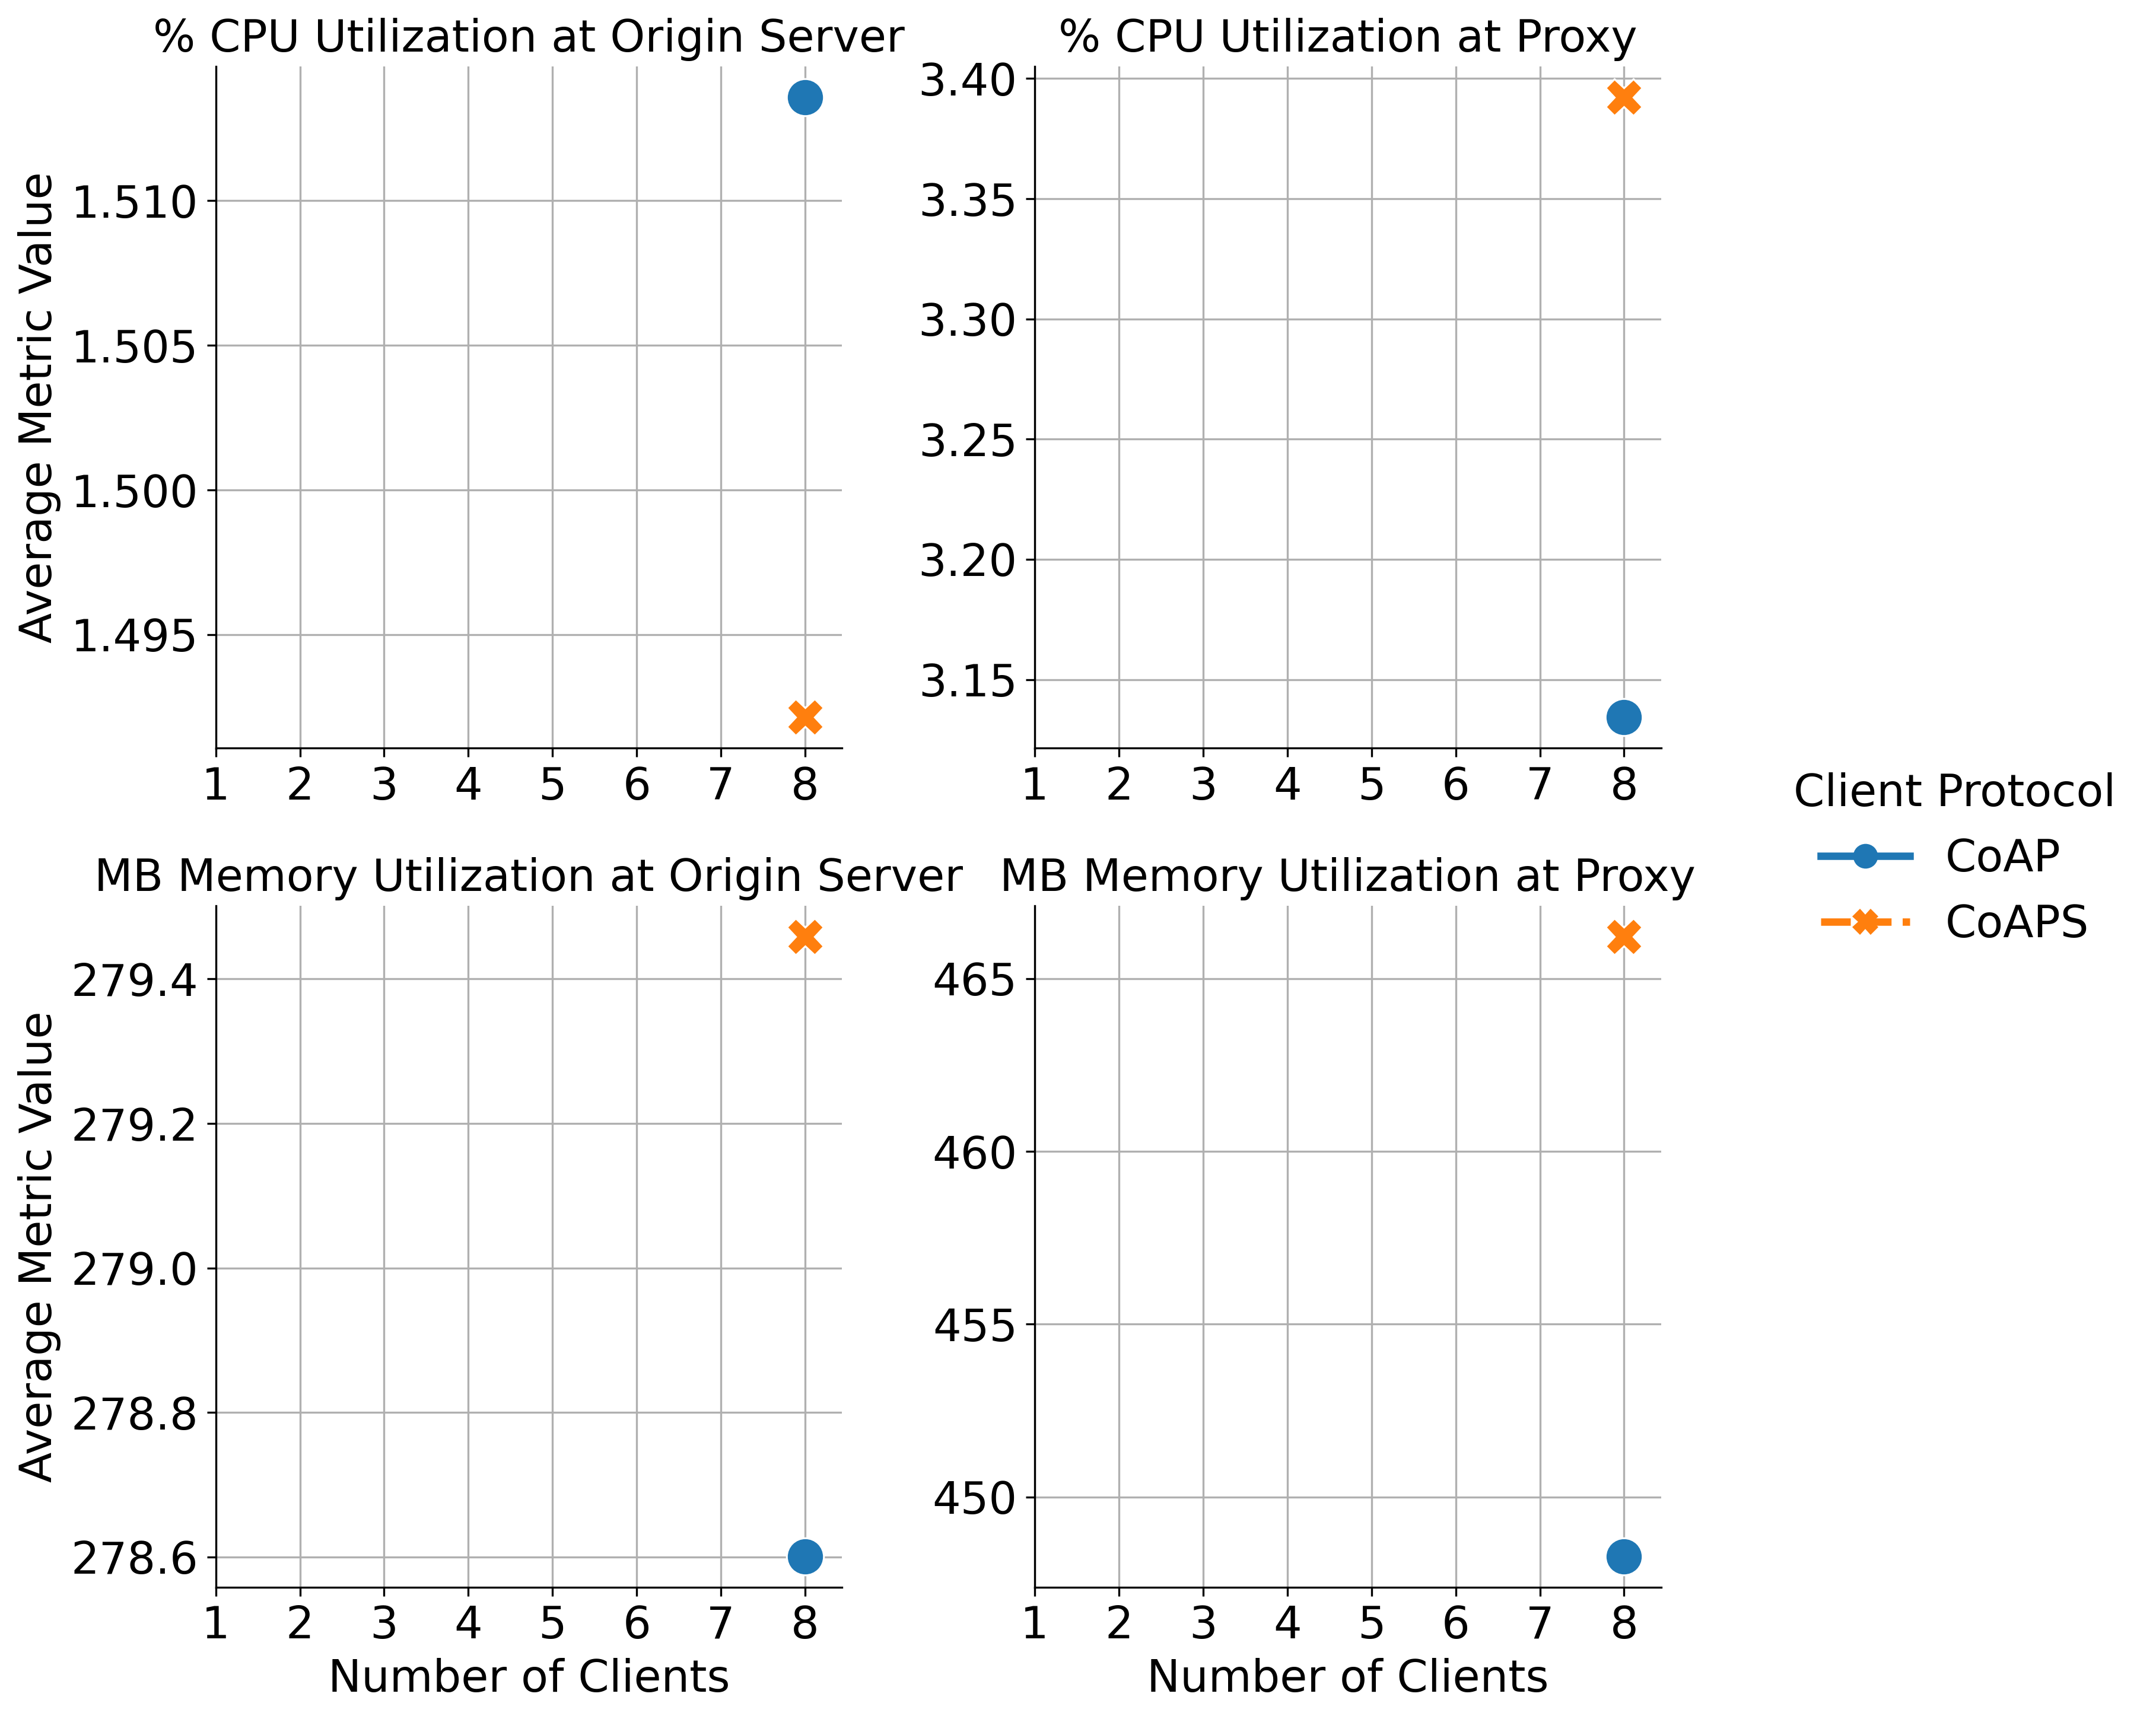

CPU times: user 2.37 s, sys: 507 ms, total: 2.88 s
Wall time: 2.33 s


,exp_id,trial,observer_id,metric_type,avg_value,min_value,max_value,attacker_rate,server_connections,max_keep_alive_requests,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,Origin Server,% CPU Utilization,1.513571,0.5,9.5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,Proxy,% CPU Utilization,3.134286,0.5,21.1,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
2,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,Origin Server,MB Memory Utilization,278.600660,265.0,280.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
3,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,Proxy,MB Memory Utilization,448.279339,244.0,487.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
4,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,Origin Server,% CPU Utilization,1.492143,0.5,10.5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAPS,True,False
5,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,Proxy,% CPU Utilization,3.392143,0.4,27.8,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAPS,True,False
6,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,Origin Server,MB Memory Utilization,279.458746,265.0,281.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAPS,True,False
7,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,Proxy,MB Memory Utilization,466.218182,245.0,502.0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAPS,True,False


In [26]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
)

g = sns.relplot(
  data=df,
  kind="line",
  x="num_clients",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": False,
  },
)

g.set_titles(
  template="{row_name} at {col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Number of Clients")
g.set_ylabels("Average Metric Value")
g.legend.set_title("Client Protocol")
g.set(xticks=np.arange(1,9,1))

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

fig.tight_layout()

plt.show()

df

In [27]:
%%time

## Measure proxy and server connection management.
##
## We currently do not insert connection events to
## the database, so we have to read from the processed
## connection files.

ALL_EXPERIMENTS_DATA_HOME = "/home/ubuntu/dos-californium/deter/expdata/real/final"

def read_exp_trial_node_connections(exp_id):
  """
  Read all processed connection dumps in an experiment `exp_id`.
  """
  experiment_dir = os.path.join(ALL_EXPERIMENTS_DATA_HOME, exp_id)

  # Explore each trial to find connection dumps.
  for trial in sorted(os.listdir(experiment_dir)):
    # Skip metadata directory.
    if trial == "metadata":
      continue

    # Since all trials are directories, skip non-directories.
    trial_dir = os.path.join(experiment_dir, trial)
    if not os.path.isdir(trial_dir):
      continue

    # Explore each file in this directory.
    for file in os.listdir(trial_dir):
      # Only keep processed connection dumps from proxy and server.
      if not (".pcap.connections.out" in file and ("proxy" in file or "server" in file)):
        continue
      connection_dump_path = os.path.join(trial_dir, file)

      # Extract the observing node's name from the file name.
      node_name = file.replace(".pcap.connections.out", "").split("_dump")[0]
      
      # Finally, read in the connection data.
      df = (
        pl
        .scan_csv(
          connection_dump_path,
          sep=";",
          quote_char='"'
        )
        .with_columns([
          pl.lit(int(trial)).alias("trial"),
          pl.lit(exp_id).alias("exp_id"),
          pl.lit(node_name).alias("observer_id"),
        ])
      )
      connection_dfs.append(df)

connection_dfs = list()
for exp_id in exp_df["exp_id"].unique():
  read_exp_trial_node_connections(exp_id)
df = pl.concat(connection_dfs).collect()

# Rename tshark column names for increased readability.
df = (
  df
  .rename({
    "_ws.col.Time"       : "timestamp",
    "_ws.col.Source"     : "src_ip",
    "_ws.col.Destination": "dst_ip",
    "tcp.srcport"        : "src_port",
    "tcp.dstport"        : "dst_port",
    "_ws.col.Length"     : "message_size_bytes",
    "_ws.col.Protocol"   : "protocol",
    "tcp.flags.syn"      : "is_syn",
    "tcp.flags.fin"      : "is_fin",
    "_ws.col.Info"       : "info",
  })
  .sort(by=["exp_id", "trial", "observer_id", "timestamp"])
)

connections_df = (
  # Filter for proxy's view of syn-acks or fin-acks coming from server
  df
  .filter(
    (pl.col("observer_id") == "proxy")
    & ((pl.col("is_syn") == 1) | (pl.col("is_fin") == 1))
    & (pl.col("info").str.contains(", ACK]"))
    & (pl.col("src_port") == 443)
  )
  # Group by experiment, trial, and observer, then accummulate
  # syn-acks and fin-acks in a list, along with their corresponding
  # timestamps of occurrence for each group.
  .groupby(
    by=["exp_id", "trial", "observer_id"],
    maintain_order=True
  )
  .agg([
    pl.col("timestamp").alias("timestamp"),
    pl.col("is_syn").cumsum().alias("cum_syn"),
    pl.col("is_fin").cumsum().alias("cum_fin"),
  ])
  # Explode the cumulative syns and fins, and their times, then
  # subtract them to get a view of how many open connections there
  # are in the experiment as a function of time
  .explode(columns=["timestamp", "cum_syn", "cum_fin"])
  .with_columns([
    (pl.col("cum_syn") - pl.col("cum_fin")).alias("open_connections")
  ])
  # And finally convert to pandas for plotting.
  .to_pandas()
)

# This method of counting does not include the original 0 connections
# at time 0 for each node in each trial -- so we add that manually.
records = list()
for e in connections_df["exp_id"].unique():
  for t in connections_df["trial"].unique():
    for o in connections_df["observer_id"].unique():
      records.append({
        "exp_id"          : e,
        "trial"           : t,
        "observer_id"     : o,
        "timestamp"       : 0.0,
        "cum_syn"         : 0,
        "cum_fin"         : 0,
        "open_connections": 0,
      })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

connections_df = (
  connections_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

connections_df

CPU times: user 1e+03 ms, sys: 912 ms, total: 1.91 s
Wall time: 381 ms


,exp_id,trial,observer_id,timestamp,cum_syn,cum_fin,open_connections,attacker_rate,server_connections,max_keep_alive_requests,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,0.000000,0,0,0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,0.067163,1,0,1,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
2,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,2.027048,2,0,2,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
3,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,3.557489,3,0,3,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
4,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,5.145646,4,0,4,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
5,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,6.046251,5,0,5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
6,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,9.723556,6,0,6,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
7,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,23.521712,7,0,7,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
8,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,23.521742,8,0,8,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
9,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,0.000000,0,0,0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAPS,True,False


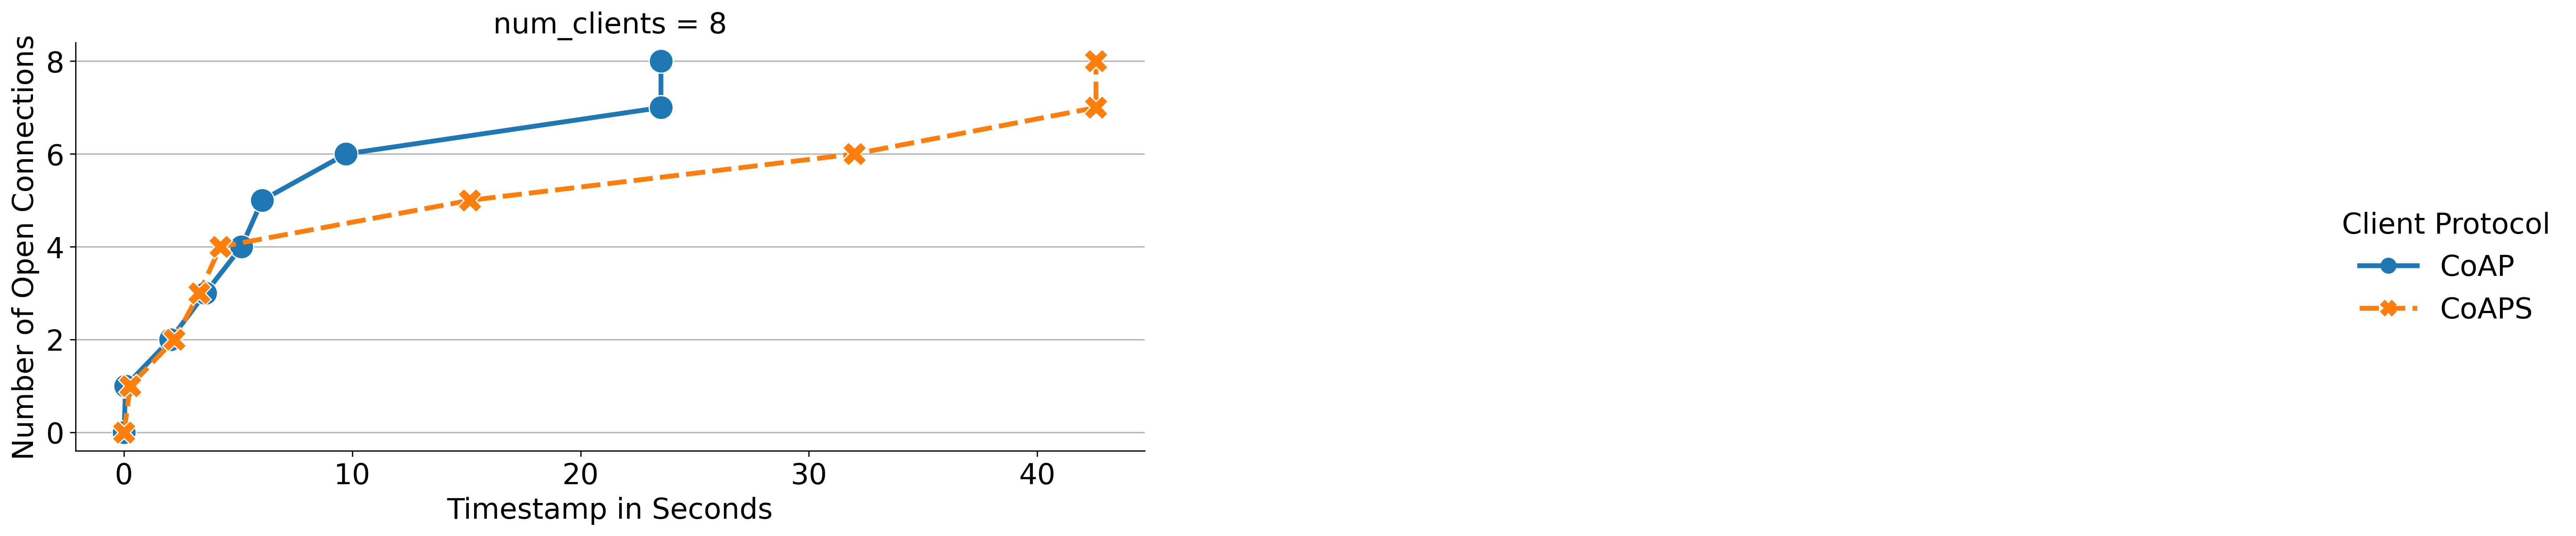

CPU times: user 1.29 s, sys: 274 ms, total: 1.56 s
Wall time: 1.24 s


In [28]:
%%time

## Measure proxy and server connection management.

df = connections_df[
  connections_df["run_attacker"] == False
]

g = sns.relplot(
  data=df,
  kind="line",
  x="timestamp",
  y="open_connections",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  col="num_clients",
  col_wrap=2,
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": False,
  },
  aspect=2,
)
g.set_xlabels("Timestamp in Seconds")
g.set_ylabels("Number of Open Connections")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

In [29]:
connections_df

,exp_id,trial,observer_id,timestamp,cum_syn,cum_fin,open_connections,attacker_rate,server_connections,max_keep_alive_requests,...,topology_name,num_proxy_connections,request_timeout,max_retries,keep_alive_duration,request_retry_interval,reuse_connections,run_proxy_with_dtls,run_proxy_with_https,run_attacker
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,0.000000,0,0,0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,0.067163,1,0,1,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
2,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,2.027048,2,0,2,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
3,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,3.557489,3,0,3,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
4,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,5.145646,4,0,4,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
5,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,6.046251,5,0,5,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
6,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,9.723556,6,0,6,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
7,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,23.521712,7,0,7,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
8,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,23.521742,8,0,8,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAP,True,False
9,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,0.000000,0,0,0,0mbps,256,0,...,thesis_cloud_proxy_and_internet_attacker,50,5,4,150,1,True,CoAPS,True,False


In [30]:
grouped_connections_df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .agg(
    mean_open_connections=("open_connections", "mean"),
    run_proxy_with_dtls=("run_proxy_with_dtls", "first"),
    num_clients=("num_clients", "first"),
  )
  .reset_index()
)

g = sns.catplot(
  data=grouped_connections_df,
  kind="bar",
  x="num_clients",
  y="mean_open_connections",
  hue="run_proxy_with_dtls",
  ci="sd",
  aspect=2,
)

grouped_connections_df

,exp_id,trial,observer_id,mean_open_connections,run_proxy_with_dtls,num_clients
0,TEST_updated_thesis_group_num_clients_8clients_noattacker_coap_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,4.0,CoAP,8
1,TEST_updated_thesis_group_num_clients_8clients_noattacker_dtls_https__140sec_proxy__30sec_attacker__120sec_client,1,proxy,4.0,CoAPS,8
